# Track TSMC with random forest

### Libraries

In [3]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # or RandomForestRegressor etc.
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
from datetime import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  # SVM Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer


## Functions

In [6]:
class PctDiffLastnight(BaseEstimator, TransformerMixin):
    def __init__(self, open_column, close_column):
        self.open_column = open_column
        self.close_column = close_column
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        prev_close = X[self.close_column].shift(1)
        pct_diff = (X[self.open_column] - prev_close) / prev_close * 100
        return pd.DataFrame(pct_diff, index=X.index, columns=['pct_diff_lastnight'])

In [8]:
class PctChangeLastday(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.pct_change() * 100
        return result.shift(1)

In [10]:
class DataLastday(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.shift(1)

In [12]:
class PctDiffToAvgLastday(BaseEstimator, TransformerMixin):
    def __init__(self, windows = [5, 10, 20, 60, 120, 240]):
        self.windows = windows
    
    def fit(self, X, y=None):
        return self
        

    def transform(self, X):
        result = pd.DataFrame(index=X.index)
        for w in self.windows:
            rolling_avg = X.rolling(window=w).mean()
            result[str(w)] = ((X - rolling_avg) / X * 100).shift(1)
        return result

In [14]:
class PctDiffToAvg(BaseEstimator, TransformerMixin):
    def __init__(self, windows = [5, 10, 20, 60, 120, 240]):
        self.windows = windows
    
    def fit(self, X, y=None):
        return self
        

    def transform(self, X):
        result = pd.DataFrame(index=X.index)
        for w in self.windows:
            rolling_avg = X.rolling(window=w).mean()
            result[str(w)] = ((X - rolling_avg) / X * 100)
        return result

In [16]:
vol_pipeline = Pipeline([
    ('vol_lastday', DataLastday()),
    ('scaler', StandardScaler())
])

In [18]:
def get_diff_label(data, openticker, closeticker, threshold = 0.004):
    df_temp = pd.DataFrame()
    df_temp['diff'] = (data[closeticker] - data[openticker]) / data[openticker]
    conditions = [
    df_temp['diff'] > threshold,
    df_temp['diff'].between(- threshold, threshold),
    df_temp['diff'] < - threshold
    ]
    choices = [1, 0, -1]
    return pd.Series(np.select(conditions, choices), index=data.index)

In [20]:
def dropna_and_align(X, y):
    X_clean = X.dropna()
    y_clean = y.loc[X_clean.index]
    return X_clean, y_clean

In [22]:
class DropNaNRows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X).dropna()

In [24]:
preprocessor = make_column_transformer(
    (PctDiffToAvgLastday(), ['Close_^GSPC']),
    (PctDiffToAvgLastday(), ['Close_TSM']),
    (PctDiffToAvgLastday(), ['Close_^SOX']),
    (PctDiffToAvg(), ['Open_2330.TW']),
    (PctDiffLastnight(open_column='Open_2330.TW', close_column='Close_2330.TW'), ['Open_2330.TW', 'Close_2330.TW']),
    (PctChangeLastday(), ['Close_^GSPC']),
    (PctChangeLastday(), ['Close_TSM']),
    (PctChangeLastday(), ['Close_^VIX']),
    (PctChangeLastday(), ['Close_^SOX']),
    (DataLastday(), ['Close_^VIX']),
    (vol_pipeline, ['Close_^GSPC']),
    (vol_pipeline, ['Close_TSM']),
    remainder='drop'  
)

## Introduce Data from: 2330, S&P500, VIX, SOX, TSM

## Assign Labels Features
### (S&P lastnight, vol; 2330 diff overnight; VIX lastnight; TSM lasnight changes, vol; SOX lastnight changes

In [28]:
data_temp = yf.download(['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], start = '2015-01-01', end = '2024-12-31') #get data through API
data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
df = data_temp.ffill() # fillup rows with NaN
df['label'] = get_diff_label(df, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')


# 1. Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# 2. Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(X_train, index=X_train_raw.index)
X_test = pd.DataFrame(X_test, index=X_test_raw.index)

X_train, y_train = dropna_and_align(X_train, y_train)
X_test, y_test = dropna_and_align(X_test, y_test)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


## Train the Model with SVM/Random Forest

In [31]:
# model = SVC(kernel='rbf', C=10, gamma='auto')  # Common setup
# model.fit(X_train, y_train)

In [33]:
# Using Random Forest
model = RandomForestClassifier(
    n_estimators=1000,  # number of trees
    max_depth=None,    # grow trees until all leaves are pure
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Evaluate the Result

In [36]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.33


In [38]:
print(y_train.value_counts(normalize=True))

label
 0    0.359473
-1    0.332497
 1    0.308030
Name: proportion, dtype: float64


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.33      0.33      0.33        85
           0       0.37      0.45      0.41       103
           1       0.26      0.20      0.22        91

    accuracy                           0.33       279
   macro avg       0.32      0.32      0.32       279
weighted avg       0.32      0.33      0.32       279



# Test run on seperate data

## Load test run data into df

In [49]:
test_run_data = yf.download(['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], start = '2024-01-01', end = '2025-03-15') #get data through API
test_run_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in test_run_data.columns] #flatten the multi-index in column
test_run_df = test_run_data.ffill() # fillup rows with NaN
test_run_df['label'] = get_diff_label(test_run_df, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')

test_run_X_raw = test_run_df.drop(columns=['label'])
test_run_y = test_run_df['label']

test_run_X = preprocessor.transform(test_run_X_raw)
test_run_X = pd.DataFrame(test_run_X, index=test_run_X_raw.index)
test_run_X, test_run_y = dropna_and_align(test_run_X, test_run_y)


[*********************100%***********************]  5 of 5 completed


## Compare the actual diff with pred

In [52]:
test_run_y_pred = model.predict(test_run_X)

test_run_accuracy = accuracy_score(test_run_y, test_run_y_pred)
print(f'Accuracy: {test_run_accuracy:.2f}')

Accuracy: 0.22


In [54]:
print(test_run_y.value_counts(normalize=True))

label
-1    0.479452
 1    0.301370
 0    0.219178
Name: proportion, dtype: float64


In [56]:
print(classification_report(test_run_y, test_run_y_pred))

              precision    recall  f1-score   support

          -1       0.25      0.03      0.05        35
           0       0.22      0.88      0.35        16
           1       0.20      0.05      0.07        22

    accuracy                           0.22        73
   macro avg       0.22      0.32      0.16        73
weighted avg       0.23      0.22      0.12        73



## Use test run data to trade and see the return/loss

In [65]:
test_run_data = pd.DataFrame()
test_run_data = fetch_data_span(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], start_time = "2020-02-25", end_time = "2024-03-15") # need first 240 row for 240MA calculation

test_run_df = pd.DataFrame()
test_run_df['2330_diff'] = test_run_data['Close_2330.TW'] - test_run_data['Open_2330.TW'] # Use this column to book the return or loss
test_run_df['2330_open'] = test_run_data['Open_2330.TW']
test_run_df['2330_diff_lastnight'] = get_pct_diff_lastnight(test_run_data, 'Open_2330.TW', 'Close_2330.TW')

# Add MA information as features
test_run_df['2330_diff_to_5d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 5) 
test_run_df['2330_diff_to_10d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 10) 
test_run_df['2330_diff_to_20d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 20) 
test_run_df['2330_diff_to_60d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 60) 
test_run_df['2330_diff_to_120d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 120) 
test_run_df['2330_diff_to_240d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 240) 

print(test_run_data['Close_^GSPC'].head())

test_run_df['SP500_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^GSPC')
test_run_df['SP500_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_^GSPC')
test_run_df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_^GSPC')

test_run_df['TSM_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_TSM')
test_run_df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_TSM')

test_run_df['VIX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^VIX')
test_run_df['VIX_lastday'] = get_data_lastday(test_run_data, 'Close_^VIX')

test_run_df['SOX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^SOX')
test_run_df['SOX_lastday'] = get_data_lastday(test_run_data, 'Close_^SOX')

test_run_df['label'] = get_diff_label(test_run_data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')
# print('df', len(test_run_df))
# print(test_run_df.head(50))


test_run_df_clean = test_run_df.dropna()
# print('df.clean', len(test_run_df_clean))


# print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))



[*********************100%***********************]  5 of 5 completed

Date
2020-02-25    3128.209961
2020-02-26    3116.389893
2020-02-27    2978.760010
2020-02-28    2954.219971
2020-03-02    3090.229980
Name: Close_^GSPC, dtype: float64


In [86]:
# trade_df = pd.DataFrame()
# X_test_run = test_run_df_clean.drop(columns = ['label', '2330_diff', '2330_open'], axis = 1)

# y_test_run_pred = model.predict(X_test_run)
# actual_diff = test_run_df_clean['2330_diff']
# trade_return = y_test_run_pred * actual_diff

# trade_cost = np.absolute(y_test_run_pred) * test_run_df_clean['2330_open']
# # print(trade_cost.head(30))
# print('Total Cost:', trade_cost.sum())
# print(trade_return.head(50))
# print('Total Return:', trade_return.sum())


In [67]:
# trade_df = pd.DataFrame()
trade_df = pd.DataFrame(index=test_run_df_clean.index)
X_test_run = test_run_df_clean.drop(columns = ['label', '2330_diff', '2330_open'], axis = 1)
trade_df['pred'] = model.predict(X_test_run)
trade_df['true_diff'] = test_run_df_clean['2330_diff']
trade_df['cost'] = test_run_df_clean['2330_open']
# print(len(test_run_df_clean))
# print(len(trade_df))

initial_capital = 1000
capital = initial_capital
capital_list = [capital]

for i in range(len(trade_df)):
    pred = trade_df['pred'].iloc[i]
    actual_diff = trade_df['true_diff'].iloc[i]
    cost = trade_df['cost'].iloc[i]

    if pred == 0:
        capital_list.append(capital)
        continue

    daily_return = pred * actual_diff / cost
    capital *= (1 + daily_return)
    capital_list.append(capital)
    
trade_df['capital'] = capital_list[1:]
print(trade_df.head(50))

final_return_pct = (capital_list[-1] - initial_capital) / initial_capital

n_days = len(trade_df)
# print(n_days)

apy = (1 + final_return_pct) ** (240 / n_days) - 1
# print(apy)
print(f"Annualized return (APY): {apy:.2%}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- SP500_diff_to_10d_avg_lastday
- SP500_diff_to_120d_avg_lastday
- SP500_diff_to_20d_avg_lastday
- SP500_diff_to_240d_avg_lastday
- SP500_diff_to_60d_avg_lastday


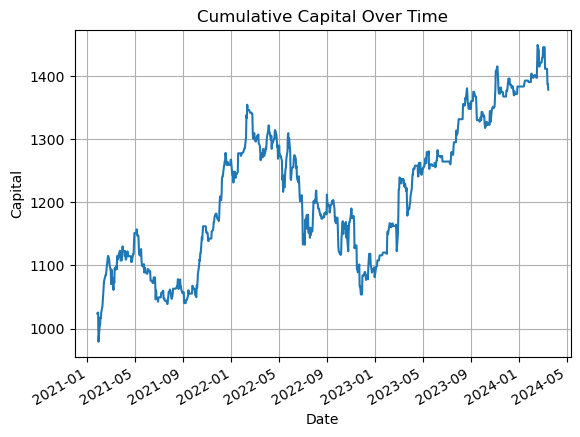

In [113]:
trade_df['capital'].plot(title='Cumulative Capital Over Time')
plt.ylabel('Capital')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## Check correlation between features

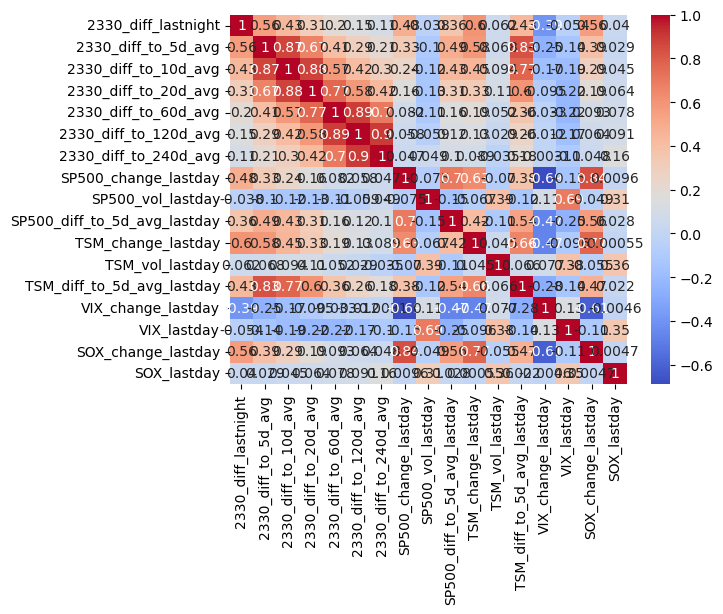

In [35]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Feature Importance

In [42]:
importances = model.feature_importances_
print(type(importances))
print(importances)

<class 'numpy.ndarray'>
[0.10613121 0.08061175 0.08988171 0.08947451 0.08496977 0.0912021
 0.08975924 0.08622937 0.09427124 0.08389085 0.10357827]


## Try finding Best-performing Hyper-perimeter

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

## Potential Idea for features

instead of 2330, use different stocks/ indexs

instead of indexes, use higher/ more direct related stocks
